# CSE527 Homework 3 - Part 2
**Due date: 23:59 on 4.14, 2023**


## Description
---
Detection is a fundamental task in CV. This homework is on based on DETR (https://arxiv.org/abs/2005.12872), one of the most famous yet simple detection model.

In this part, you will get familiar with DETR code base and will be modfiying the code (https://github.com/facebookresearch/detr/tree/main) to perfrom a new task: **_Detection using Centroids_**.

Traditionally bounding boxes are used to highlight detections, however in this homework you will perfrom detection of an object by selecting a _meaningful_ center point on it. We will call that point the centroid.
  





## Code
---
Although DETR is simple relative to other detection models, the code to train and test is still complex and is spread acorss multiple directories. For this reason, the code is provided in a zipped package (here [detr.zip](https://drive.google.com/file/d/11EQSULAdjYliUGAezqEu9iAoQem9ilFT/view?usp=drive_link)).

To pull this code into your colab, you have to first add the zip file as shortcut to current working directory. To do this, open the above link and click on "Add shortcut to Drive" button (drive symbol with a plus) and navigate to working current directory and add shortcut.

You have to repeat the same process to download this [coco dataset](https://drive.google.com/file/d/1dLeL-B7Bd9t6Ii1DBKib9c9_2aqaWyvu/view?usp=drive_link).

In [58]:
HW3_ROOT_PATH = '/content/drive/MyDrive/' + 'Colab Notebooks/Debnath_Tanoy_116084356_hw3/' #'FILL IN YOUR HOMEWORK3 ROOT HERE'
PATH_TO_PART2 = HW3_ROOT_PATH + 'part2/'
PATH_TO_COCO = HW3_ROOT_PATH + 'coco/'
# TRY to use these variable wherever you load/save some file

In [59]:
from google.colab import drive
drive.mount('/content/drive/')
# CD into root of your homework2 part3 directory
%cd -q $PATH_TO_PART2

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ls

CSE527_24S_HW3_P2.ipynb  detr


In [60]:
# !unzip -n detr.zip

In [61]:
%cd detr
%mkdir checkpoints

/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356_hw3/part2/detr
mkdir: cannot create directory ‘checkpoints’: File exists


## Install dependencies
---
If you are using colab, running below cell will suffice, else refer to requirements.txt to install all dependencies

In [62]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-j__3fp4w
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-j__3fp4w
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


##Model
---
DETR consists of
- a feature extractor,
- transformer and
- two output heads
    - classification head
    - regression head

In the original implementation, regression head is designed to output the bouding box attributes ltrb (left, top, right, & bottom edges of object). In this homework we intend to train the model to output the centeroids of each object.

###How do we define centroids:###
Original DETR uses the MS COCO's _bbox_ annotations to train the model, while in this HW we will use the _segmentation_ annotations.
Each image may have multiple objects. The pixel outline of each object is provided as an annotation. We will use this contour information to generate the object mask.




## Get yourself familiar with Data set
---

To get your self familiar with the dataset, you are encouraged to play around with the COCO API. The sample code  given below displays the segmentation data format. In the later sections you will be using the segmentation data to estimate a centroid.  

In [63]:
from pycocotools.coco import COCO
from PIL import Image
from hubconf import _make_detr
import torch
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T

coco = COCO('instances_train2017.json')
ids = coco.getImgIds()
sample = 0
im = coco.loadImgs(ids[sample])[0]
print(f'Image keys: {im.keys()}')
annos = coco.loadAnns(coco.getAnnIds(ids[sample]))
# Note: segmentation annotation is in the format of [x1, y1, x2, y2, x3, y3, . . . ], where (x1, y1) is a point
# on countour, x being dist from left and y is dist from top row of image
print(f'Anno segmentation: {(annos[0]["segmentation"])}')
############# (0 points) ########################
anns = coco.loadAnns(coco.getAnnIds(81922))
segmentations = [ann['segmentation'] for ann in anns]
#################################################


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Image keys: dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
Anno segmentation: [[264.97, 195.87, 273.93, 200.95, 290.07, 203.63, 336.67, 200.95, 365.95, 201.24, 377.0, 207.82, 365.35, 213.79, 361.47, 214.09, 361.17, 218.87, 358.78, 222.46, 357.59, 216.78, 330.7, 216.18, 330.7, 222.75, 320.24, 221.86, 314.27, 218.87, 303.21, 219.77, 304.41, 222.75, 307.1, 226.34, 301.12, 226.64, 299.33, 230.22, 294.55, 223.35, 298.13, 222.16, 298.13, 220.66, 280.51, 219.47, 263.48, 218.57, 238.98, 213.79, 220.75, 209.61, 224.94, 208.41, 218.07, 205.13, 227.03, 205.43, 218.36, 184.51, 227.03, 183.32, 246.15, 202.14, 254.81, 206.02, 274.23, 204.83, 263.48, 198.26, 264.97, 194.67]]


In [64]:
# Image height and width
print(f"Image height: {im['height']}")
print(f"Image width: {im['width']}")

Image height: 426
Image width: 640


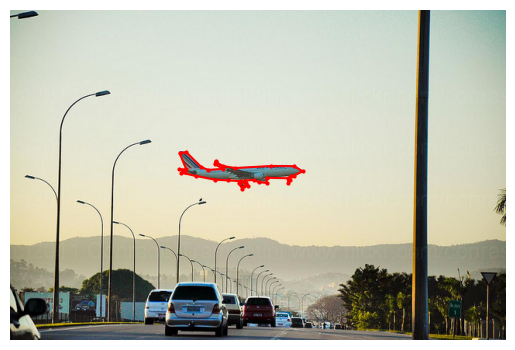

In [65]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_coco_img(sample):
    img_id = ids[sample]

    # Load image information
    im_info = coco.loadImgs(img_id)[0]

    # Load image
    img_data = requests.get(im_info['coco_url']).content
    img = Image.open(BytesIO(img_data))

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Load and display annotations on the image
    annotations = coco.loadAnns(coco.getAnnIds(img_id))
    for ann in annotations:
        segmentation = ann['segmentation'][0]  # Assuming there is only one segmentation (list of x, y points)
        segmentation_pairs = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]

        # Plot the segmentation on the image
        plt.plot(*zip(*segmentation_pairs), marker='o', color='red', markersize=2)

    # Show the image with annotations
    plt.show()
display_coco_img(0)

## Complete the code
---

This provided detr/ folder has the following structure
```
detr/
├── datasets/
│   ├── coco.py
│   ├── ...
├── models/
│   ├── detr.py
│   ├── matcher.py
│   └── ...
├── utils/
│   └── ...
├── engine.py
├── main.py
├── requirements.txt
└── README.md
```

In these python files, you will be implementing the missing code blocks. These blocks are highlited by the TODOs
```#### TODO CSE527 STUDENT CODE STARTS HERE ######```


In total there are 5 sections the code has to be filled. They are located in the files: coco.py, detr.py, matcher.py.  

To complete this part you are very much encouraged to:
- understand how dataset, data sampler, dataloader, model, loss, & optimizer work together during training  
- refer to the actual DETR implementation at [git:facebookresearch/detr](https://github.com/facebookresearch/detr/tree/main) to get an idea of the training pipeline.
- try to understand flow of control from main.py.

You cannot complete the missing code blocks just from the given description in this ipynb, so you must read the code around. That is, you will read the inputs, outputs and how the inputs to the code block are created and how the outputs from the code block will be utilized.   

## Task
You should modify the DETR to output centroids rather than bounding boxes.   
Dataset:
At the dataset level, you are not actually given the centroids, so you will use the instance segmentation masks to estimage the centroid for each object in annotation.

Model:
For this you will need to replace the classification and regression heads (already removed in the code provided to you, you just need to add new).



### 1 - coco.py: ConvertCocoPolysToMask.\__call__()  [10 points]
Here you will be writing the logic to convert annotations to centroids in the following method.
Note: You will have to figure out the inputs and outputs by yourself.  
```
def convert_coco_poly_to_centroids(segmentations, h, w, boxes) -> Torch.Tensor(shape = num_segmentations x 2)
```

This method is part of data loader, and is called when generating the <sample, prediction> pairs, which will eventually be passed onto model for training.

The centroid we are referring to is the point where the center of mass of the mask is located.

steps:

convert segmentations into masks [5 points]

compute the center of mass of the mask [5 point]

Feel free to pass on more inputs/outputs to the above method to support your way of computing centroids.


### 2 & 3 - detr.py: DETR.\__init__(), DETR.forward() [10 points]

This is the DETR model architectrure. Here you will change the classification and regression heads, so the model can output centroids (unlike bboxes in original implementation).
Also you will write logic to freeze the remaining section of DETR.

Original model takes 300 hours to completely train from scrtch, so it is important to freeze all weights except necessary ones (heads).

### 4 - matcher.py: HungarianMatcher.forward() [20 points]

Matcher is a key part of detection models. Refer to the paper or original DETR implementation to see how/why matcher is used. In this implementation we use Hungarian algorithm to align predictions to the ground truths.

Breif:  
All object instance predictions are matched against the ground truth objects. This is necessary to compute the loss.
Basically matcher will guess which ground truth object each prediction might be referring based on the closeness of predicted centroids and ground truth centroids.

100 centroid predictions will be matched against the ground truth centroids. You will compute a cost matrix that encdes the relation of prediction to GT.

Refer: https://en.wikipedia.org/wiki/Hungarian_algorithm

How you compute the cost matrix is again upto you.

### 5 - detr.py: SetCriterion.loss_centroid() [15 points]

Here you will implement the loss function. Given the predicted centroids and ground truth centroids (which you processed in coco.py), you will write logic to compute variable _centroid_loss_

The loss method is up to you.  

Note: At code blocks 4 & 5, make sure the loss/cost is in the normalized range only. I.e., loss/cost is calculated on normalized inputs.




## Computing centroid
---

Below block provide you a sandbox environment to play around and create a centroid finding algorithm. You will eventually use this code at detr/dataset/coco.py to complete the traning pipeline.

Try to produce centroids that are within 10 pixels a far from the provided gt centroids.

#### 1.1 Finding mask from the segments

426 640


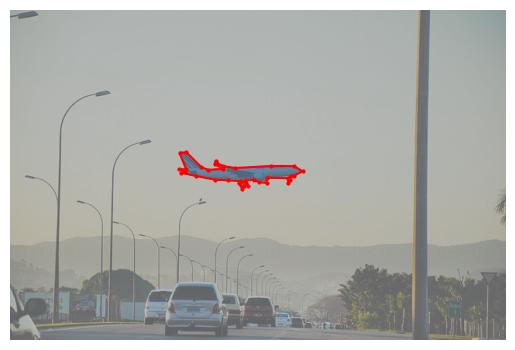

In [66]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools import mask as coco_mask

def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


def display_coco_img(sample):
    img_id = ids[sample]

    im_info = coco.loadImgs(img_id)[0]

    img_data = requests.get(im_info['coco_url']).content
    img = Image.open(BytesIO(img_data))

    # Display image
    plt.imshow(img)
    plt.axis('off')

    print(im['height'], im['width'])

    annotations = coco.loadAnns(coco.getAnnIds(img_id))
    combined_masks = torch.zeros(im_info['height'], im_info['width'], dtype=torch.uint8)
    all_masks = []

    for ann in annotations:
        segmentation = ann['segmentation'][0]  # Assuming there is only one segmentation (list of x, y points)
        segmentation_pairs = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]

        masks = convert_coco_poly_to_mask([ann['segmentation']], im_info['height'], im_info['width'])

        # To make sure that the mask remains binary
        combined_masks = torch.logical_or(combined_masks, masks[0]).byte()

        # Storing individual masks
        all_masks.append(masks[0])

        plt.imshow(np.asarray(masks[0]), alpha=0.4, cmap='gray', interpolation='none')

        # Plot the segmentation on the image
        plt.plot(*zip(*segmentation_pairs), marker='o', color='red', markersize=2)

    plt.imshow(combined_masks, alpha=0.4, cmap='Blues', interpolation='none')

    all_masks_tensor = torch.stack(all_masks)

    # Show the image with annotations
    plt.show()
    return combined_masks, all_masks

combined_masks, all_masks = display_coco_img(0)

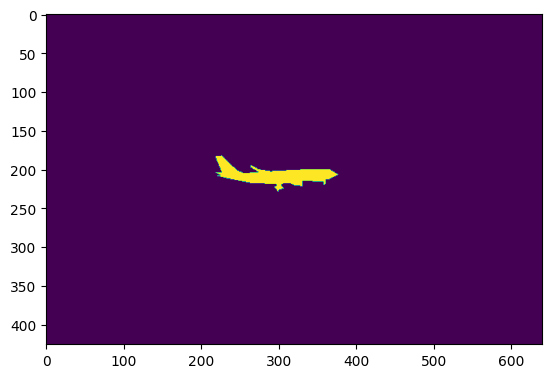

In [67]:
plt.imshow(np.asarray(combined_masks))
plt.show()

In [68]:

from scipy import ndimage
from pycocotools.mask import frPyObjects, decode
from scipy import ndimage


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = frPyObjects(polygons, height, width)
        mask = decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


def convert_coco_poly_to_centroids(segmentations, height, width, bboxes):
    """Converts COCO polygon annotations to centroids.
    Args:
        segmentations: A list of COCO polygon annotations.
        height: The height of the image.
        width: The width of the image.
        boxes: bounding boxes

    Returns:
        A PyTorch tensor containing the centroids of the objects in the image.
    """
    masks = convert_coco_poly_to_mask(segmentations, height, width)
    centroids = []
    for mask in masks:
        # Apply binary erosion to remove small objects
        mask = ndimage.binary_erosion(np.asarray(mask), iterations = 5).astype(np.asarray(mask).dtype)

        r, c = mask.shape[0], mask.shape[1]

        ## THIN SECTION REMOVAL

        # Conver to tensor
        mask_tensor = torch.from_numpy(mask)

        # Sums of the mask along rows and columns
        row_sum = torch.sum(mask_tensor, dim=0)
        col_sum = torch.sum(mask_tensor, dim=1)

        # Medians of non-zero values
        row_median = torch.median(row_sum[row_sum > 0])
        col_median = torch.median(col_sum[col_sum > 0])

        # Replace all values below median with 0
        col_sum[col_sum < col_median] = 0
        row_sum[row_sum < row_median] = 0

        # Replace all values equal to or greater than median with 1
        col_sum[col_sum >= col_median] = 1
        row_sum[row_sum >= row_median] = 1

        # Create masks for rows and columns
        row_median_mask = np.zeros([r, c], dtype=int)
        col_median_mask = np.zeros([r, c], dtype=int)

        # In the row mask, set each row of the column mask with median-high values to be True
        col_mask = (col_sum == 1)
        row_median_mask[col_mask, :] = True

        # In the column mask, set each column of the row mask with median-high values to be True
        row_mask = (row_sum==1)
        col_median_mask[:, row_mask] = True

        # Take the reverse of the column mask and logical AND to the row mask
        mask3 = ~col_median_mask
        row_median_mask[mask3] = False

        # Convert original mask to boolean
        bool_mask = (mask == 1)

        # Set the non-median-high indices from the row mask to be zero in the original mask
        mask[row_median_mask==0] = 0

        # Set the False indices from the boolean mask to be 0
        mask[bool_mask == 0] = 0

        # Logical AND the boolean mask for 1 and the row mask for 1 to set only acceptable indices to 1 in the mask
        mask[(bool_mask == 1) & row_median_mask==1] = 1

        ## COMPUTE CENTROID
        centroidx, centroidy = ndimage.center_of_mass(mask)
        centroids.append([centroidy, centroidx])
    return torch.FloatTensor(centroids)




Predicted centroids: tensor([[301.4694, 209.4617]])


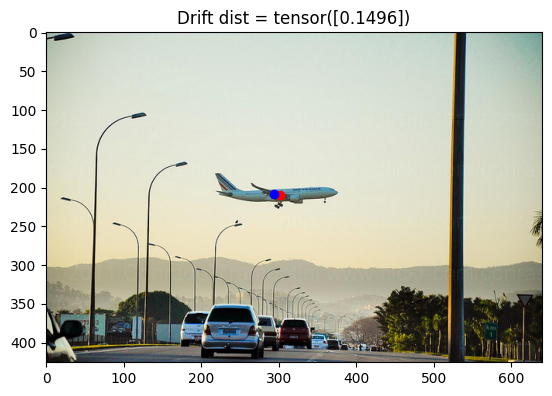

In [69]:
def estimate_centroids(img, anns):
    h, w = img['height'], img['width']
    # Get segmentations and convert them to centroids
    segmentations = [ann['segmentation'] for ann in anns]
    boxes = [obj["bbox"] for obj in anns]
    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=w)
    boxes[:, 1::2].clamp_(min=0, max=h)
    return convert_coco_poly_to_centroids(segmentations, h, w, boxes)


def compute_drift_rate(centroids, gt_centroids, gt_areas):
  distance_matrix = torch.cdist(centroids, gt_centroids)
  distances = []
  equivalent_lengths = []
  for i in range(len(centroids)):
      min_distance = torch.min(distance_matrix[i])
      min_distance_index = torch.argmin(distance_matrix[i])
      distances.append(min_distance)
      equivalent_lengths.append(np.sqrt(gt_areas[min_distance_index]))
  return torch.div(torch.Tensor(distances), torch.Tensor(equivalent_lengths))


# driver code
img_id = 81922
img = coco.loadImgs(img_id)[0]
img_data = Image.open(requests.get(img['coco_url'], stream=True).raw)

# Get image annotations
anns = coco.loadAnns(coco.getAnnIds(img_id))
centroids = estimate_centroids(img, anns)
gt_centroids = torch.Tensor([[294, 208]])
print(f'Predicted centroids: {centroids}')
plt.imshow(img_data)
for centroid in centroids:
    plt.plot(centroid[0], centroid[1], 'ro')
for centroid in gt_centroids:
    plt.plot(centroid[0], centroid[1], 'bo')
# Show image
plt.title(f'Drift dist = {compute_drift_rate(centroids, gt_centroids, [ann["area"] for ann in anns])}')
plt.show()

## Training
---

Implement all five mentioned code blocks and use the below command AS IS. You can change BS, num_epochs, num_workers. (use this output training  [log](https://drive.google.com/file/d/1ZGd-ciOKkajri0GEOwc-uJDBjGJHJdNY/view?usp=drive_link) for your reference).

Make sure checkpoints are being saved correctly and sometime not mistakenly being overriden due to multiple executions.

You can use the validation loss/loss_centroid  as a metric to track performance.

For grading:
- There are no strict limits on evaluation metrics.
- In the last cell of this notebook _avg_drift_rate_ metric is computed on a subset of validation ds. Try to score below 0.35.





In [70]:
!python -u main.py --coco_path '/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356_hw3/coco/' --batch_size 10 --num_workers 12 --epochs 20 --output_dir './checkpoints'  --resume https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --freeze_body

Not using distributed mode
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
git:
  sha: N/A, status: clean, branch: N/A

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=10, weight_decay=0.0001, epochs=20, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, freeze_body=True, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_centroid=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, cent_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356_hw3/coco/', coco_panoptic_path=None, remove_difficult=False, output_dir='./checkpoints', device='cuda', seed=42, resume='https://dl.fbaipu

## Visualizing
---------------

In [71]:
device = torch.device('cuda')
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



def rescale_center(out_bbox, size):
    img_w, img_h = size
    b = out_bbox * torch.tensor([img_w, img_h], dtype=torch.float32, device=device)
    return b

def detect(im, model, transform, det_threshold = 0.75):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img.to(device))

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > det_threshold

    # convert boxes from [0; 1] to image scales
    centroids = rescale_center(outputs['pred_centroids'][0, keep], im.size)
    return probas[keep].detach().cpu(), centroids.detach().cpu()

def getImg(url):
    return Image.open(requests.get(url, stream=True).raw)

def is_grayscale(image):
    if image.mode == "L":
        return True
    else:
        return False

def convert_grayscale_to_rgb(image):
    if not is_grayscale(image):
        return image
    else:
        return image.convert("RGB")


def plot_results(pil_img, prob, centroids, gt_centroids, boxes, file_name):
    # plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    ax.scatter([c[0] for c in gt_centroids], [c[1] for c in gt_centroids], color='blue', s=10)
    ax.scatter([c[0] for c in centroids], [c[1] for c in centroids.cpu()], color='red', s=10)
    if show_center:
        ax.scatter([c[0]+c[2]//2 for c in boxes], [c[1]+c[3]//2 for c in boxes], color='green', s=10)
    for (xc, yc, w, h), c in zip(boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xc, yc), w, h,
                                   fill=False, color='white', linewidth=2))
    if show_probs:
        for p, c in zip(prob, centroids):
            cl = p.argmax()
            text = f'- {p[cl]:0.2f}'
            ax.text(c[0] + 15, c[1], text, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    # plt.savefig(f'images/{file_name}')
    plt.show()



### before submission run below cell with display_results=True

In [72]:
display_results = True
show_probs = True
show_center = True
det_threshold = 0.7

model = _make_detr('resnet50', num_classes=2)
model.to(device)

checkpoint = torch.load('checkpoints/checkpoint.pth', map_location='cpu')
print("DETR returning", {n:p for n,p in model.named_parameters()}.keys())

model.load_state_dict(checkpoint['model'])
model.eval()
if not os.path.exists('images'):
    os.mkdir('images')

coco = COCO(PATH_TO_COCO + 'annotations/instances_val2017.json')
ids = coco.getImgIds()

val_drift_rates = []
for id in range(20):
    im = coco.loadImgs(ids[id])[0]
    annos = coco.loadAnns(coco.getAnnIds(ids[id]))
    img = getImg(im['coco_url']).convert("RGB")
    scores, centroids = detect(img, model, transform, det_threshold=det_threshold)
    gt_centroids = estimate_centroids(im, annos)
    plot_results(img, scores, centroids, gt_centroids, [anno['bbox'] for anno in annos], im['file_name'])
    drift_rates = compute_drift_rate(centroids, gt_centroids, [anno['area'] for anno in annos])
    print(f'im: {ids[id]}, drift rates : {drift_rates.cpu().numpy()}')
    val_drift_rates.append(drift_rates)
filtered_drift_rates = [drift_rates for drift_rates in val_drift_rates if not np.isnan(drift_rates).any()]
overall_drift_rates = torch.cat(filtered_drift_rates, dim=0)
if overall_drift_rates.numel() > 0:
    average_drift_rate = overall_drift_rates.mean().item()
    print(f'Average drift rate: {average_drift_rate}')
else:
    print('No valid drift rates found.')

Output hidden; open in https://colab.research.google.com to view.

## Discussion
---

1. ***Which distance metric have you used for computing the cost matrix between centroids? why?*** [2 points]


Answer:
I have calculated the cost matrix between centroids using the Minkowski distance, also known as the Minkowski metric, which is a generalization of the Manhattan distance and the Euclidean distance.

This is done for p-norm using the torch.cdist function, and for the norm, I use p=1.

By dividing the cost by the greatest value, the cost is normalized over the range of cost values.




2. ***Why freezing the entire model and traning just the heads might never actually predict the true centroids?*** [3 points]


Answer:
The network builds up knowledge of features from lower to higher level, and freezing the layers prevents the network from gaining knowledge of features particular to centroid prediction.

It is unrealistic to expect the network to use higher attributes learned for bounding box prediction to predict the centroids properly.








## Submission guidelines
---



The submission structure should look like:

IMPORTANT: Remove the _checkpoint.pth_ and make sure _heads.pth_ is in the submission.


```
{last name}_{first name}_{sbu id}_hw2/
├── part1/
│   └── ...
├── part2/
│   ├── CSE527_24S_HW3_P2.ipynb
│   └── detr/
│       ├── checkpoints/
│       │   └── heads.pth
│       ├── datasets/
│       │   ├── coco.py
│       │   ├── ...
│       │   └── ...
│       ├── models/
│       │   ├── detr.py
│       │   ├── matcher.py
│       │   ├── ...
│       │   └── ...
│       ├── utils/
│       │   ├── ...
│       │   └── ...
│       ├── engine.py
│       ├── main.py
│       ├── hubconf.py
│       └── requirements.txt
```


Follow instructions in part1's submission guidelines to generate your complete submission